In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/diabetes-data-set/diabetes.csv


# Dataset Description

The data is taken from "https://www.kaggle.com/mathchi/diabetes-data-set"

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases.All the patients here are female 21 years or older.It contains the following columns:
 
  - Pregnancies: Number of times pregnant
  - Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
  - BloodPressure: Diastolic blood pressure (mm Hg)
  - SkinThickness: Triceps skin fold thickness (mm)
  - Insulin: 2-Hour serum insulin (mu U/ml)
  - BMI: Body mass index (weight in kg/(height in m)^2)
  - DiabetesPedigreeFunction: Diabetes pedigree function
  - Age: Age (years)
  - Outcome: Class variable (0 or 1)

# Objectives

- Clean the data and deal with missing values
- Perform EDA to get a better understanding of underlying trends
- Fit different models and tune their hyperparameter for best performance

# Data Cleaning

In [5]:
data = pd.read_csv("../input/diabetes-data-set/diabetes.csv")

In [6]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
print("Data has\033[1m" , data.shape[0] , "\033[0mrows and\033[1m", data.shape[1] , "\033[0mcolumns\n\n")
print("Column Name \t\t Data Type\n")
print(data.dtypes) 

Data has 768 rows and 9 columns


Column Name 		 Data Type

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object


In [8]:
data.isnull().sum() # no missing values at first glance

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [9]:
data.duplicated().sum() #no duplicated values

0

In [10]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


We note that minimum value for columns such as Glucose,BP,Insulin,BMI are 0 which is not possible , hence these must be missing values which are encoded as 0
We can use imputation techniques to deal with these

In [11]:
corrupted_data = data.loc[:,'Glucose':'BMI']

In [12]:
corrupted_data.replace(0,np.nan,inplace=True) # replace 0 with NaN

In [13]:
data.loc[:,'Glucose':'BMI'] = corrupted_data

In [14]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [15]:
data.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Lets observe these missing values more closely and find out if their is any relation

In [16]:
import missingno as msno

<AxesSubplot:>

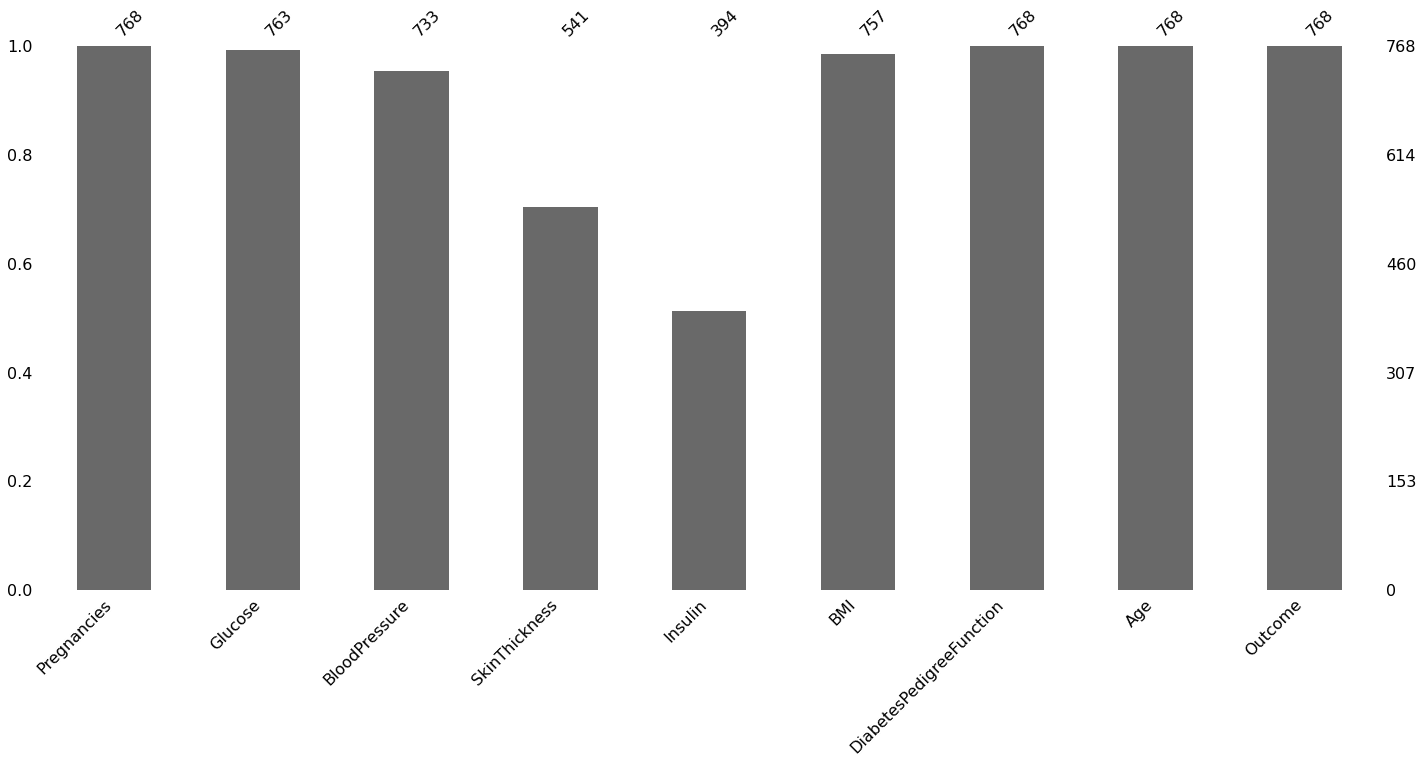

In [17]:
msno.bar(data)

<AxesSubplot:>

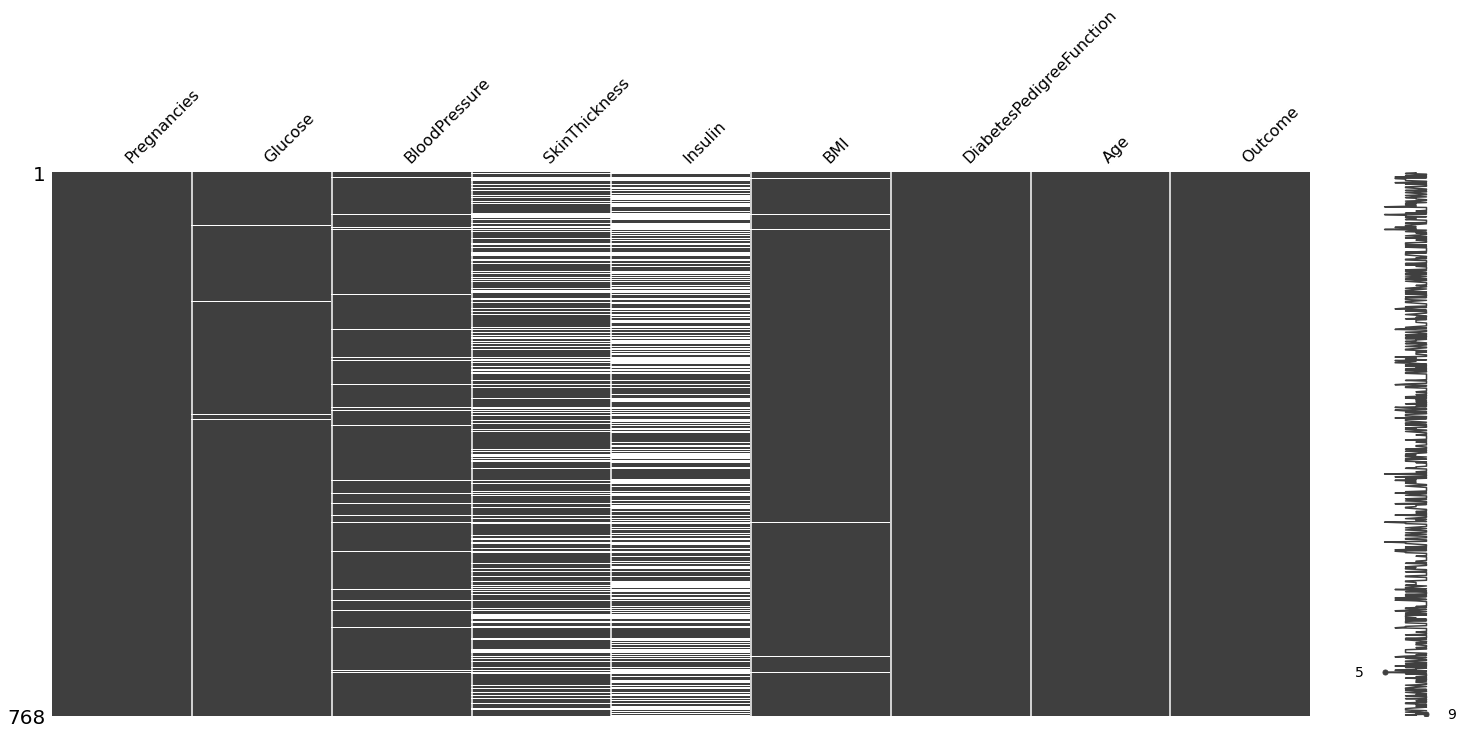

In [18]:
msno.matrix(data)

<AxesSubplot:>

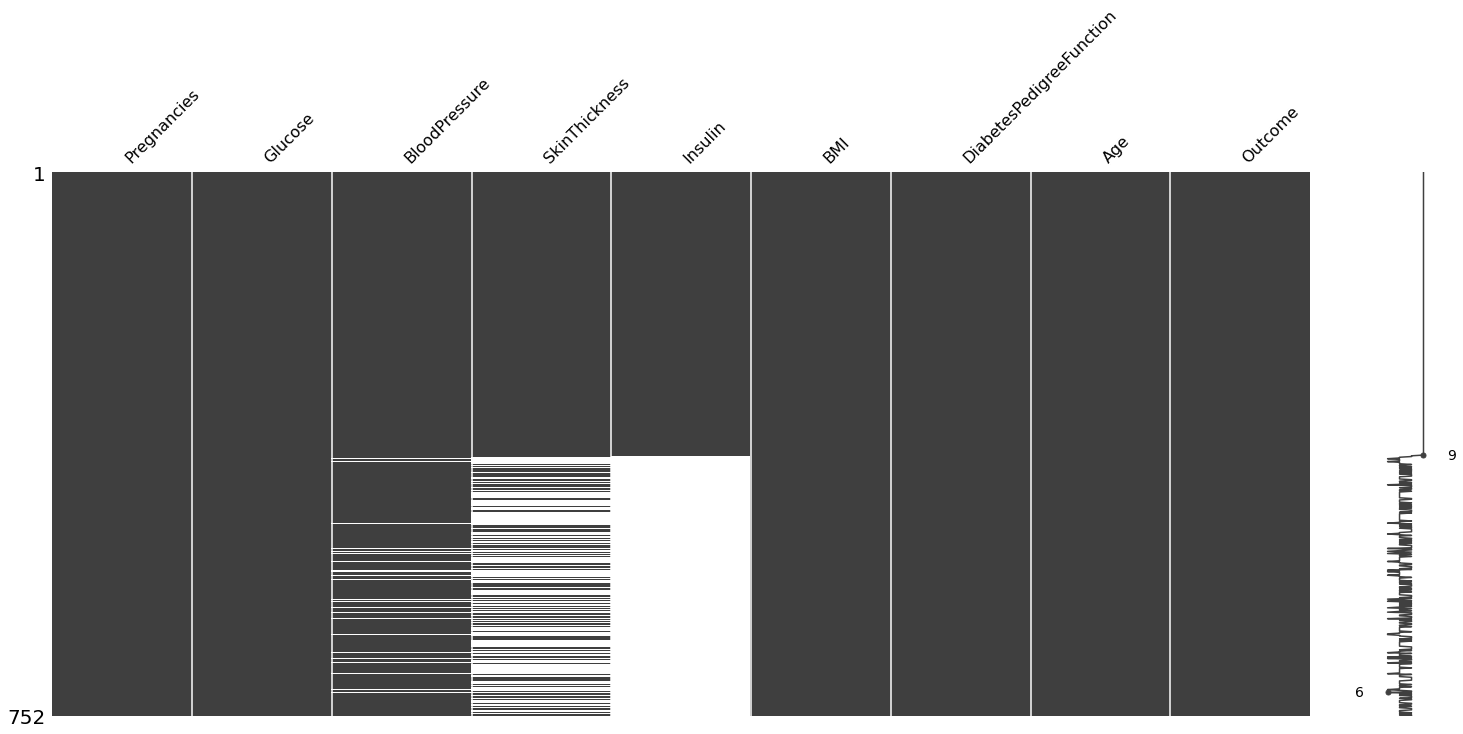

In [22]:
msno.matrix(data.sort_values(by="Insulin"))

Looking at the above matrix we can figure out that glucose and BMI are MCAR(Missing completely at random) and insulin , SkinThickness are MNAR(Missing not at random)

<AxesSubplot:>

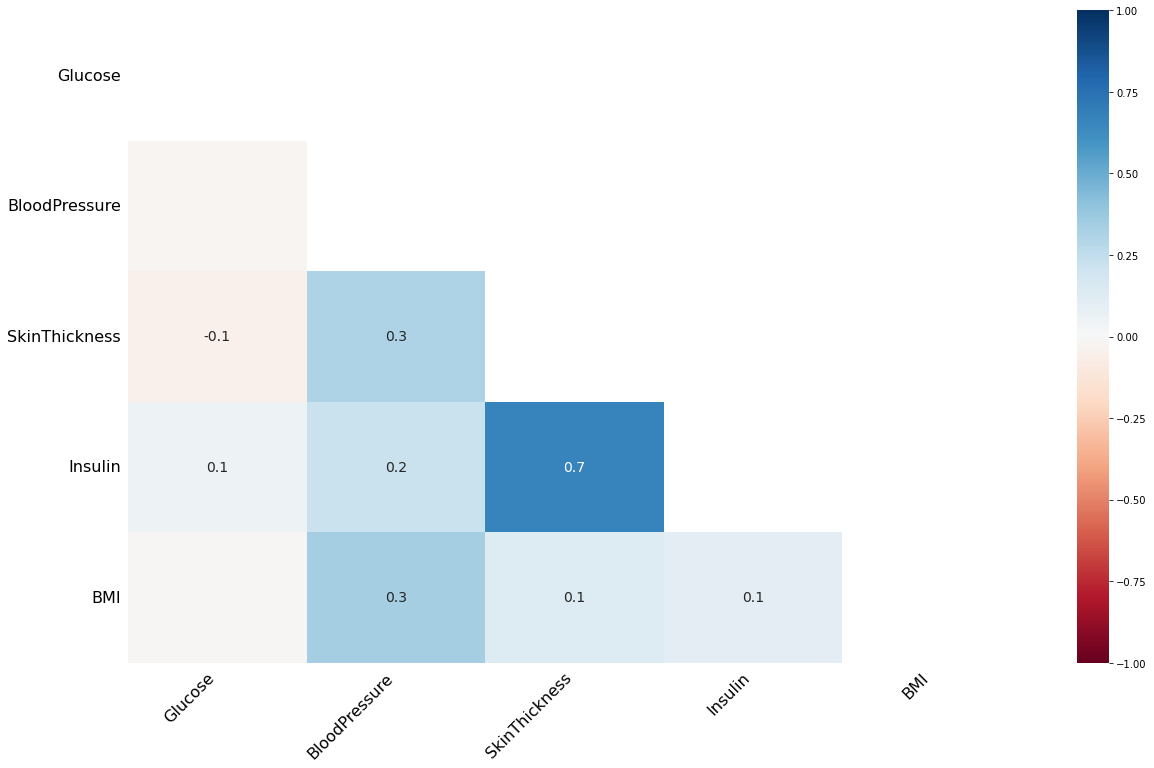

In [20]:
msno.heatmap(data)

We can see heavy correlation between SkinThickness and Insulin

In [21]:
data.dropna(subset=['Glucose','BMI'],inplace=True) # drop rows having missing values for Glucose or BMI

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [24]:
from sklearn.impute import KNNImputer

In [25]:
data_knn = data.copy()

In [26]:
knn_imputer = KNNImputer(n_neighbors=5)
data_knn.iloc[:,:] = knn_imputer.fit_transform(data_knn)

Using knnimputer we fill the missing values without impacting the variability of the dataset

In [27]:
data_knn.shape

(752, 9)

In [28]:
data_knn.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000,752.000000
mean,3.851064,121.941489,72.413830,29.102128,154.656649,32.454654,0.473051,33.312500,0.351064
std,3.375189,30.601198,12.223965,9.473877,98.872359,6.928926,0.330108,11.709395,0.477621
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,23.000000,90.000000,27.500000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,135.000000,32.300000,0.377000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,34.650000,191.850000,36.600000,0.627500,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# Outlier Removal

In [29]:
cleaned_data = data_knn.copy()

<AxesSubplot:xlabel='Pregnancies'>

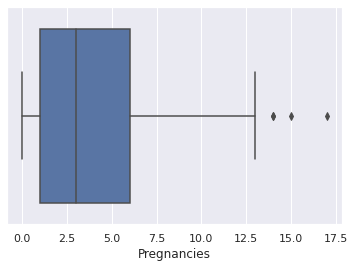

In [30]:
sns.boxplot(data=data_knn,x='Pregnancies')

Values above 13 are outliers and removed 

In [31]:
cleaned_data = cleaned_data[cleaned_data['Pregnancies']<=13]

<AxesSubplot:xlabel='Pregnancies'>

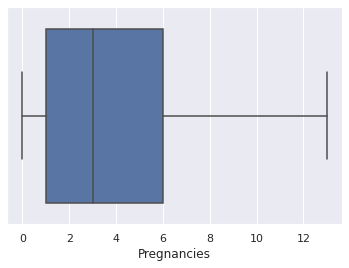

In [32]:
sns.boxplot(data=cleaned_data,x='Pregnancies')

Verify the outlier removal

In [ ]:
sns.boxplot(data=data_knn,x='Glucose')

No outliers detected

<AxesSubplot:xlabel='BloodPressure'>

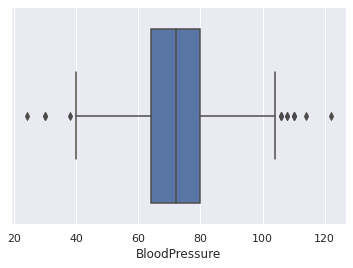

In [33]:
sns.boxplot(data=data_knn,x='BloodPressure')

BP below 30 mm Hg can be considered as outliers and hence removed

In [37]:
cleaned_data = cleaned_data[cleaned_data['BloodPressure']>=30]

<AxesSubplot:xlabel='BloodPressure'>

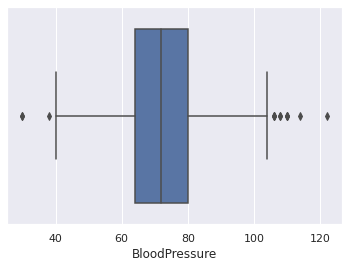

In [39]:
sns.boxplot(data=cleaned_data,x='BloodPressure')

Verify outlier removal effect

<AxesSubplot:xlabel='Insulin'>

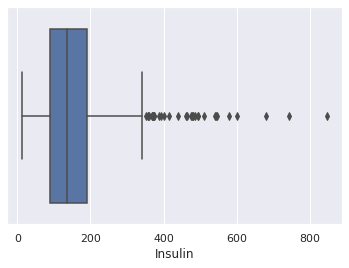

In [40]:
sns.boxplot(data=data_knn,x='Insulin')

Insulin level above 500 could skew our model and hence removed

In [41]:
cleaned_data = cleaned_data[cleaned_data['Insulin']<=500]

<AxesSubplot:xlabel='SkinThickness'>

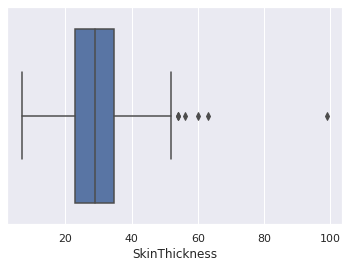

In [42]:
sns.boxplot(data=data_knn,x='SkinThickness')

SkinThickness of 99 removed as outlier

In [45]:
cleaned_data = cleaned_data[cleaned_data['SkinThickness']<=80]

<AxesSubplot:xlabel='BMI'>

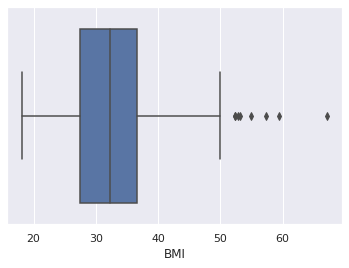

In [44]:
sns.boxplot(data=data_knn,x='BMI')

BMI obove 60 removed 

In [46]:
cleaned_data = cleaned_data[cleaned_data['BMI']<=60]

<AxesSubplot:xlabel='Age'>

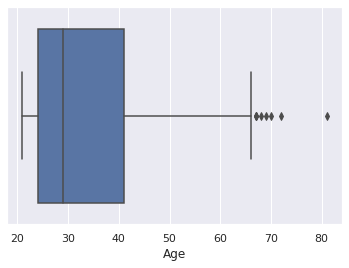

In [47]:
sns.boxplot(data=data_knn,x='Age')

Age of 81 is removed as outlier

In [48]:
cleaned_data = cleaned_data[cleaned_data['Age']<=70]

In [49]:
print("We removed",data_knn.shape[0]-cleaned_data.shape[0],"outliers")

We removed 18 outliers


# Exploratory Data Analysis

<AxesSubplot:>

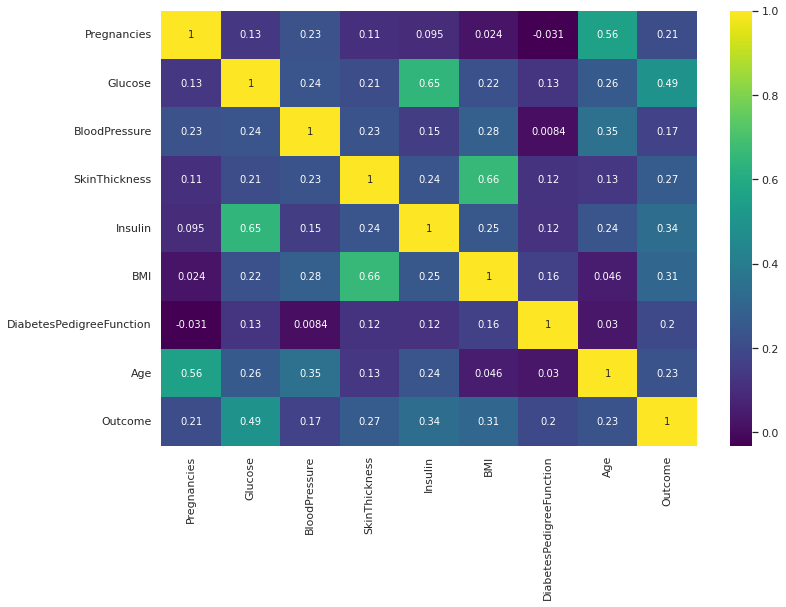

In [50]:
plt.figure(figsize=(12,8))
sns.heatmap(cleaned_data.corr(),annot=True,cmap='viridis')

The following conclusions can be drawn from the heatmap :
- There is not much correlation among different predictors
- Age and Pregnancy have a positive corr indicating that adults have more children
- There is high corr between BMI and SkinThickness, generally people with very high BMI are considered obese thus explaining thicker skin
- There is positive correlation among Insulin and Glucose as well which could be explained by the fact that perhaps the type 1 diabetic patients who generally have high Glucose , were given Insulin injections.
- Glucose also has corr with our Outcome , i.e. , diabetic patients have higher level of glucose in their blood

<AxesSubplot:xlabel='Age', ylabel='Pregnancies'>

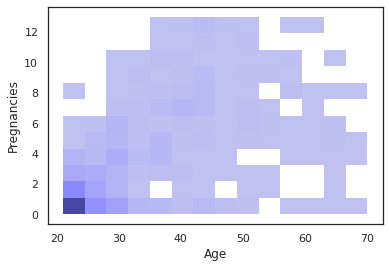

In [51]:
sns.set_style('white')
sns.histplot(data=cleaned_data,x='Age',y='Pregnancies',color='darkblue')

Females between age of 40 and 50 have more children while those around the age of 21 generally have 0 children

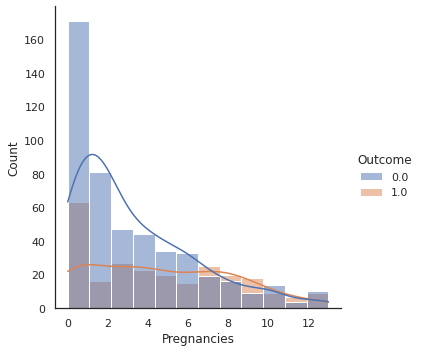

In [52]:
sns.displot(data=cleaned_data,x='Pregnancies',hue='Outcome',kde=True)

Majority of females taking part have 0 preganancies , also the number of pregnancies doesn't seem to have impact on wether someone is diabetic or not

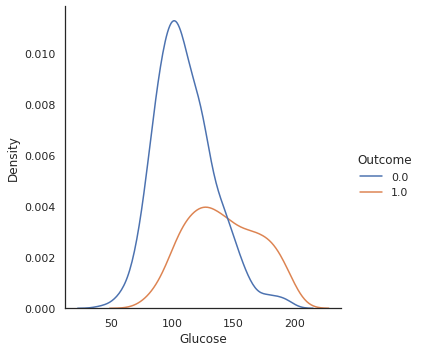

In [53]:
sns.displot(data=cleaned_data,x='Glucose',hue='Outcome',kind='kde')

People who don't have diabeties have glucose normally distributed around 100 as mean , while those with diabeties have much higher level of glucose ranging between 100 and 200

<AxesSubplot:xlabel='Glucose', ylabel='Insulin'>

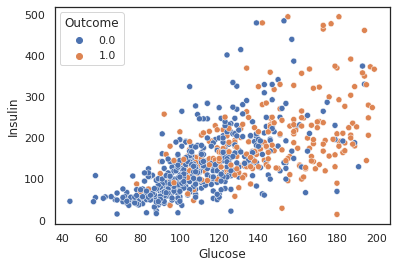

In [54]:
sns.scatterplot(data=cleaned_data,x='Glucose',y='Insulin',hue='Outcome')

Type 1 diabeties is caused when pancreas produces very little to no insulin and thus the level of glucose increases , from the scatterplot we can clearly see that diabetic patients have high glucose and low insulin 

##### Note: Data is collected after 2 hour of giving an insulin injection which explains the high values of insulin.

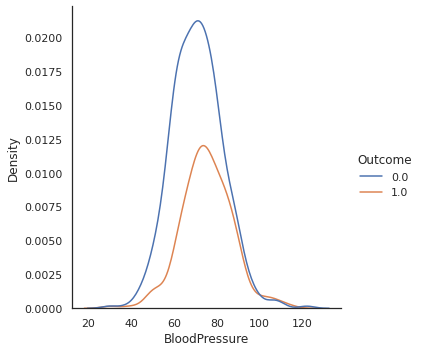

In [55]:
sns.displot(data=cleaned_data,x='BloodPressure',hue='Outcome',kind='kde')

BloodPressure seems to be normally distributed for both positive and negative cases, indicating little corr as we have seen earlier. The mean BloodPressure seems to be a bit higher but is still within the normal diastolic range of 60-80 mm Hg

<AxesSubplot:xlabel='BMI', ylabel='SkinThickness'>

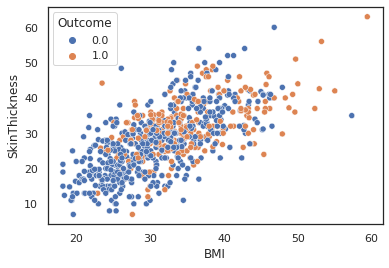

In [56]:
sns.scatterplot(data=cleaned_data,y='SkinThickness',x='BMI',hue='Outcome')

BMI range of 18.5-24.9 is generally considered as normal while those above 30 are considerd as obsese ans BMI above 55 is considerd as Morbid Obsese
With increase in BMI skinthickness also increases and it seems that obses people are generally more prone to diabeties

In [57]:
cleaned_data['Outcome'].value_counts(normalize=True)*100

0.0    65.667575
1.0    34.332425
Name: Outcome, dtype: float64

The dataset seems to be imbalanced with 65% of input as non diabetic , we will use SMOTE to deal with this later as we train our model

# Metric
It is important to identify the correct metric for a classification problem with unbalanced dataset as accuracy would fail 
Since we are trying to build a model to corretly identify patients with Diabeted we should prioritize our recall or f1 score.

# Logistic Regression

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [61]:
X = cleaned_data.drop('Outcome',axis=1)  # predictor variables
y = cleaned_data['Outcome']  # outcome variable

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,stratify=y,random_state=42) #with stratify=True we get same proportion in our train test split as in our original dataset

In [63]:
sm = SMOTE(random_state=42) # initalize SMOTE
x_res,y_res=sm.fit_resample(X_train,y_train) # Oversample our data.

In [ ]:
#select best params
from sklearn.model_selection import GridSearchCV
estimator = Pipeline([("scaler", StandardScaler()),
        ("logistic_regression", LogisticRegression(solver='liblinear'))])

params = {'logistic_regression__penalty' : ['l1','l2'],
    'logistic_regression__C': np.linspace(0.001,100)
}
grid = GridSearchCV(estimator, params, cv=5,verbose=True,n_jobs=-1,scoring='recall')

In [ ]:
grid.fit(x_res,y_res) #fit the model

In [ ]:
grid.best_params_ #best params

In [ ]:
y_pred = grid.predict(X_test)  #predict 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
#plot the confusion matrix
_, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='viridis', annot_kws={"size": 40, "weight": "bold"})  
labels = ['True', 'False']
ax.set_xticklabels(labels, fontsize=25);
ax.set_yticklabels(labels, fontsize=25);
ax.set_ylabel('Prediction', fontsize=30);
ax.set_xlabel('Ground Truth', fontsize=30)

In [ ]:
print(classification_report(y_test,y_pred))

A recall of 0.75 is not that bad , lets see if we can improve upon in other models

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
se = StandardScaler()  # we need to scale our data for knn
X_scaled = se.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33,stratify=y,random_state=42)

In [ ]:
sm = SMOTE(random_state=42)
x_res,y_res=sm.fit_resample(X_train,y_train)

In [ ]:
#to optimize the value of k 
from sklearn.metrics import recall_score,f1_score
max_k = 40
recall_scores = list()
f1_scores = list()
for k in range(1, max_k):
    
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn = knn.fit(x_res, y_res)
    
    y_pred = knn.predict(X_test)
    r = recall_score(y_pred, y_test)
    recall_scores.append((k, round(recall_score(y_test, y_pred), 4)))
    f1_scores.append((k, round(f1_score(y_test, y_pred), 4)))
    
r_results = pd.DataFrame(recall_scores, columns=['K', 'Recall'])
f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1'])

In [ ]:
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = r_results.set_index('K').plot(figsize=(12, 8), linewidth=6)
ax.set(xlabel='K', ylabel='Recall')
ax.set_xticks(range(1, max_k, 2));
plt.title('KNN recall')
plt.legend(labels='R')

In [ ]:
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = f1_results.set_index('K').plot(figsize=(12, 8), linewidth=6)
ax.set(xlabel='K', ylabel='f1_score')
ax.set_xticks(range(1, max_k, 2));
plt.title('KNN F1')
plt.legend(labels='f1_score')

From both the recall and F1 score we can see that k=13 can be considered as an optimal value

In [ ]:
_, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='viridis', annot_kws={"size": 40, "weight": "bold"})  
labels = ['True','False']
ax.set_xticklabels(labels, fontsize=25);
ax.set_yticklabels(labels, fontsize=25);
ax.set_ylabel('Prediction', fontsize=30);
ax.set_xlabel('Ground Truth', fontsize=30)
### END SOLUTION

In [ ]:
knn = KNeighborsClassifier(n_neighbors=13, weights='distance')
knn = knn.fit(x_res, y_res)
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

KNN focused more heavily on identifying the False negatives

# SVC

For our next two models let's try and optimize for f1 score and see the results

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,stratify=y,random_state=42)

In [ ]:
sm = SMOTE(random_state=42)
x_res,y_res=sm.fit_resample(X_train,y_train)

In [ ]:
from sklearn.model_selection import GridSearchCV
estimator = Pipeline([("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(max_iter=100000))])

params = {
    'linear_svc__C': np.linspace(0.001,100)
}
grid = GridSearchCV(estimator, params, cv=5,verbose=True,n_jobs=-1,scoring='f1')

In [ ]:
grid.fit(x_res,y_res)

In [ ]:
grid.best_params_

In [ ]:
y_pred = grid.predict(X_test)

In [ ]:
_, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='viridis', annot_kws={"size": 40, "weight": "bold"})  
labels = ['True','False']
ax.set_xticklabels(labels, fontsize=25);
ax.set_yticklabels(labels, fontsize=25);
ax.set_ylabel('Prediction', fontsize=30);
ax.set_xlabel('Ground Truth', fontsize=30)
### END SOLUTION

In [ ]:
print(classification_report(y_test, y_pred))

Similar results to that of Logistic Regression 

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,stratify=y,random_state=42)

In [ ]:
sm = SMOTE(random_state=42)
x_res,y_res=sm.fit_resample(X_train,y_train)

In [ ]:
from sklearn.model_selection import GridSearchCV
estimator = RandomForestClassifier(n_estimators=300)

params = { 'max_depth' : range(5,20),
          'min_samples_split' : np.arange(2,10)
}
grid = GridSearchCV(estimator, params, cv=5,verbose=True,n_jobs=-1,scoring='f1')

In [ ]:
grid.fit(x_res,y_res)

In [ ]:
y_pred = grid.predict(X_test)

In [ ]:
_, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='viridis', annot_kws={"size": 40, "weight": "bold"})  
labels = ['True','False']
ax.set_xticklabels(labels, fontsize=25);
ax.set_yticklabels(labels, fontsize=25);
ax.set_ylabel('Prediction', fontsize=30);
ax.set_xlabel('Ground Truth', fontsize=30)
### END SOLUTION

In [ ]:
grid.best_params_

In [ ]:
print(classification_report(y_test, y_pred))

Again similar results compared to the other models, with very little to no improvement in our scores

# Combining models 
Lets try and combine all our models and see how well it works then

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
lr = LogisticRegression(solver='liblinear',penalty='l1',C=2.0417959183673466)
knn = KNeighborsClassifier(n_neighbors=13, weights='distance')
svc = LinearSVC(penalty='l2',C=0.001)
rf = RandomForestClassifier(max_depth=8, min_samples_split=2,n_estimators=300)

In [ ]:
eclf = VotingClassifier(estimators=[('clf1',lr),('clf2',knn),('clf3',svc),('clf4',rf)])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42,stratify=y)

In [ ]:
sm = SMOTE(random_state=42)
x_res,y_res=sm.fit_resample(X_train,y_train)

In [ ]:
eclf.fit(x_res,y_res)

In [ ]:
y_pred = eclf.predict(X_test)

In [ ]:
_, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='viridis', annot_kws={"size": 40, "weight": "bold"})  
labels = ['False', 'True']
ax.set_xticklabels(labels, fontsize=25);
ax.set_yticklabels(labels[::-1], fontsize=25);
ax.set_ylabel('Prediction', fontsize=30);
ax.set_xlabel('Ground Truth', fontsize=30)
### END SOLUTION

In [ ]:
print(classification_report(y_test, y_pred))

Still the same results , which is not surprising considering that all the models had similar predictions

# Conclusion

All the models had similar performance with recall around 0.75, which is not bad considering the size of the dataset and the imbalance.

However perhaps employing unsupervised methods such as clustering could reveal more information and help us improve our scores.
More powerful ensemble methods such as XGboost could also yield better result and I would like to try that perhaps some other day.

Also other sampling methods might have yielded better results.

In the end I would like your feedback on how i could improve the performance, thank you.